In [72]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

import nibabel as nib
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader

In [73]:
%load_ext autoreload
%autoreload 2
from model.uunet_3d import UNet
from processing.dataloader import load_train_images, binarize_image, channel_to_second_dim, trainData, scaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA

In [74]:
X_raw = load_train_images('data_processed/x_images/', shape=(32,32,32))
Y_raw = load_train_images('data_processed/y_images/', shape=(32,32,32))
print(type(X_raw),X_raw.shape)
print(type(Y_raw),Y_raw.shape)

<class 'numpy.ndarray'> (219, 32, 32, 32)
<class 'numpy.ndarray'> (219, 32, 32, 32)


In [75]:
Y_bin = binarize_image(Y_raw,2,1)
Y_bin.shape

(219, 32, 32, 32)

In [76]:
X_scaled = scaler(X_raw, 255.0)

In [77]:
X_scaled = scaler(X_raw, 255.0)
X_pp = torch.from_numpy(X_scaled)
Y_pp = torch.from_numpy(Y_bin)

Classes in label: [0. 1.]


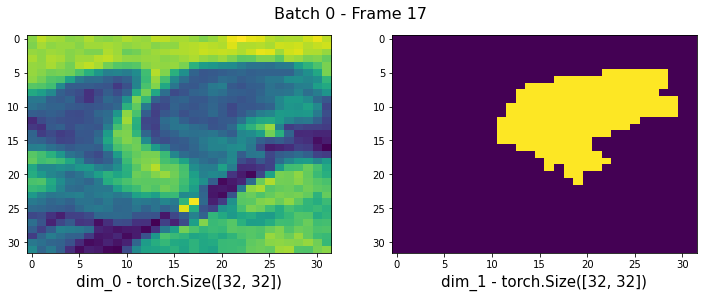

In [78]:
batch_image = 0
image_index = 17
rows, cols = 1, 2
image_set = [X_pp[batch_image,:,:,image_index],Y_pp[batch_image,:,:,image_index]]
image_name = ['dim_0','dim_1','dim_2']
fig, ax = plt.subplots(rows, cols, figsize=(12,4))
fig.suptitle('Batch {} - Frame {}'.format(batch_image, image_index), fontsize=16)
for row in range(rows):
    for col in range(cols):
        plot_image = image_set[col]
        ax[col].imshow(plot_image, aspect='auto')
        ax[col].set_xlabel("{} - {}".format(image_name[col],plot_image.shape), fontsize=15)
print('Classes in label:',np.unique(Y_pp[batch_image,:,:,image_index]))

In [79]:
X = channel_to_second_dim(X_pp)
print(X.shape)

Y = channel_to_second_dim(Y_pp)
print(Y.shape)

(batch, channel D, H, W)
torch.Size([219, 1, 32, 32, 32])
(batch, channel D, H, W)
torch.Size([219, 1, 32, 32, 32])


Classes in label: [0. 1.]


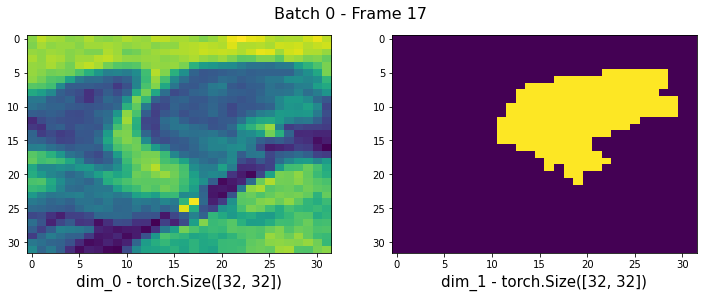

In [80]:
batch_image = 0
image_index = 17
rows, cols = 1, 2
image_set = [X[batch_image,0,image_index,:,:],Y[batch_image,0,image_index,:,:]]
image_name = ['dim_0','dim_1','dim_2']
fig, ax = plt.subplots(rows, cols, figsize=(12,4))
fig.suptitle('Batch {} - Frame {}'.format(batch_image, image_index), fontsize=16)
for row in range(rows):
    for col in range(cols):
        plot_image = image_set[col]
        ax[col].imshow(plot_image, aspect='auto')
        ax[col].set_xlabel("{} - {}".format(image_name[col],plot_image.shape), fontsize=15)
print('Classes in label:',np.unique(Y[batch_image,:,image_index,:,:]))

In [81]:
BATCH_SIZE = 16

In [82]:
train_data = trainData(X, Y)
print('Images:',len(train_data))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
print('Batches:',len(train_loader))

Images: 219
Batches: 14


## Model and Train

In [83]:
f1 = 64
filters = [f1, f1 * 2, f1 * 4, f1 * 8, f1 * 16]
filters

[64, 128, 256, 512, 1024]

In [85]:
EPOCHS = 5
LEARNING_RATE = 0.001

model = UNet(filters=filters)
#loss = nn.CrossEntropyLoss()
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device("cpu")
print(device)

model.to(device)
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        #print(y_pred[0])
        #print('y_pred', y_pred[0].shape)
        
        
        loss_calc = loss(y_pred[0], y_batch)#.type(torch.LongTensor))
        #print(loss_calc)

        
        loss_calc.backward()
        optimizer.step()
        
        epoch_loss += loss_calc.item()

        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

cpu


ValueError: Target size (torch.Size([16, 1, 32, 32, 32])) must be the same as input size (torch.Size([16, 2, 32, 32, 32]))

In [29]:
model.eval()
print('')

In [30]:
nii_file  = nib.load('data/hippo_train.nii.gz')
nii_data = nii_file.get_fdata()
print(type(nii_data))
print('Height, Width, N_images, Channels')
print(nii_data.shape)

<class 'numpy.ndarray'>
Height, Width, N_images, Channels
(32, 32, 32)


In [31]:
x = torch.from_numpy(nii_data)
print(x.shape)
print(x.dtype)

torch.Size([32, 32, 32])
torch.float64


In [32]:
x = x.permute(2, 0, 1)
print(x.shape)
print(x.dtype)

torch.Size([32, 32, 32])
torch.float64


In [33]:
x = torch.unsqueeze(x, dim=0)
print(x.shape)
print(x.dtype)

torch.Size([1, 32, 32, 32])
torch.float64


In [34]:
x = torch.unsqueeze(x, dim=0)
print(x.shape)
print(x.dtype)

torch.Size([1, 1, 32, 32, 32])
torch.float64


In [35]:
y_result = model(x.float())

In [36]:
print(len(y_result))
y_result[0].shape

1


torch.Size([1, 1, 32, 32, 32])

In [37]:
torch.save(y_result[0], 'prediction/my_pred_tensor.pth')

In [68]:
import datetime
datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")

'07_28_2022_00:03:52'

In [71]:
sys.path

['/home/warrior/Documents/ss_superbio/code/appstore/uunet_train_app',
 '/home/warrior/miniconda3/envs/dl/lib/python39.zip',
 '/home/warrior/miniconda3/envs/dl/lib/python3.9',
 '/home/warrior/miniconda3/envs/dl/lib/python3.9/lib-dynload',
 '',
 '/home/warrior/miniconda3/envs/dl/lib/python3.9/site-packages']